🔧 Code modifié pour fonctionner dans Jupyter Notebook
📊 Workflow simplifié : Extraction → Analyse → Export
📊 Utilisez : display_workflow_graph() pour voir le graphique
📝 Utilisez : result = process_pdf('2025.4.sante.pdf', 117, 131)
📋 Utilisez : show_final_results(result) pour voir tous les résultats
🎨 Affichage du graphique du workflow original...
📊 Graphique du workflow LangGraph :


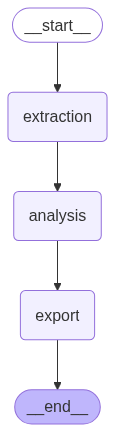


🎨 Affichage du graphique du workflow d'analyse de synthèse...
📊 Graphique du workflow d'analyse de synthèse :


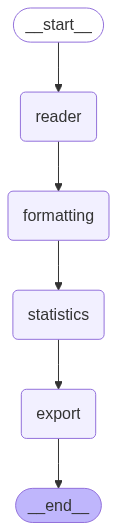


🧪 Test du workflow LangGraph PDF...
📄 Traitement du PDF par tranches de 2 pages de 117 à 131

🔍 Traitement des pages 117 à 118
🚀 Démarrage du workflow LangGraph...
🔍 Exécution du nœud d'extraction...
✅ Extraction terminée. Fichier sauvé: C:\Users\kosmo\pycode\LangGraph\textes_extraits\2025.5.sante_pages_117-118.txt
🔬 Exécution du nœud d'analyse...
✅ Analyse terminée.
📤 Exécution du nœud d'export...
✅ Markdown créé : 2025.5.sante_analyse_20250714_090317.md
✅ Export terminé


              
              === RÉSULTATS DU WORKFLOW COMPLET ===
              
              
              

📁 PDF traité: 2025.5.sante.pdf
📄 Pages analysées: 117 à 118
💾 Fichier extrait: C:\Users\kosmo\pycode\LangGraph\textes_extraits\2025.5.sante_pages_117-118.txt

📤 Fichiers exportés:
   📄 Markdown: 2025.5.sante_analyse_20250714_090317.md
   📕 PDF: N/A
   📋 JSON: N/A

=== ANALYSE DÉTAILLÉE ===
Voici l'analyse du texte selon les instructions fournies :

**Article 1**
[En cas d'absence ou d'empêchement de] : d

In [3]:
import os
import pdfplumber
import re
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional
from reportlab.lib.pagesizes import letter, A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
import json
from datetime import datetime
from IPython.display import Image, display

# Configuration
BASE_DIR = os.path.abspath(r"C:\Users\kosmo\pycode\LangGraph")

# Initialiser le LLM
api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    print("⚠️ ATTENTION: Utilisez une variable d'environnement  ")
    api_key = "sk-proj-0 MX6_U0pycw_XiZUUtZ4V6Gc5x "

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=api_key
)

# ===== STATE DEFINITION =====

class PDFAnalysisState(TypedDict):
    pdf_filename: str
    start_page: Optional[int]
    end_page: Optional[int]
    extracted_text: Optional[str]
    extracted_file_path: Optional[str]
    analysis_result: Optional[str]
    statistics_result: Optional[str]  # Nouveau champ
    exported_files: Optional[dict]
    error: Optional[str]

# ===== STATE DEFINITION POUR SYNTHÈSE =====

class SynthesisAnalysisState(TypedDict):
    synthesis_file_path: str
    synthesis_content: Optional[str]
    formatted_content: Optional[str]
    statistics_content: Optional[str]
    exported_files: Optional[dict]
    error: Optional[str]

# ===== EXTRACTION FUNCTIONS =====

def post_process_text(text):
    """Fonction pour nettoyer et reformater le texte extrait."""
    # Corriger "A\nrticle" en "Article"
    text = re.sub(r'A\s*\n\s*rticle\s+(\d+)', r'Article \1', text)
    
    # Corriger "E\nn cas" en "En cas"
    text = re.sub(r'E\s*\n\s*n cas', r'En cas', text)
    
    # Corriger les sauts de lignes intempestifs dans le texte courant
    text = re.sub(r'(\w)\s*\n\s*(\w)', lambda m: f"{m.group(1)} {m.group(2)}" if not (m.group(2).lower() == 'les' or m.group(1) == '-') else f"{m.group(1)}\n{m.group(2)}", text)
    
    return text

def format_articles(text):
    """Améliore le formatage des articles pour respecter la mise en page désirée"""
    # Mettre "Article XX" sur une ligne séparée et ajouter un saut de ligne après
    text = re.sub(r'\b(Article\s+\d+)\s+', r'\n\1\n\n', text)
    
    # Assurer que "Direction de" commence toujours sur une nouvelle ligne
    text = re.sub(r'([^\n])(Direction de)', r'\1\n\n\2', text)
    
    # Assurer que chaque élément commençant par un tiret est sur une nouvelle ligne
    text = re.sub(r'([^\n])\s*(-\s+)', r'\1\n\2', text)
    
    # Assurer que "dans la limite de ses attributions et fonctions :" est sur sa propre ligne
    text = re.sub(r'(dans la limite de ses attributions et fonctions\s*:)', r'\n\1\n', text)
    
    # S'assurer que le texte après un tiret soit bien séparé de la Direction qui suit
    text = re.sub(r'(afférents\.)\s*(Direction)', r'\1\n\n\2', text)
    text = re.sub(r'(comptes\.)\s*(Direction)', r'\1\n\n\2', text)
    
    # S'assurer que "Bulletin officiel" est au début d'une ligne
    text = re.sub(r'([^\n])(Bulletin officiel)', r'\1\n\2', text)
    
    # Nettoyer les lignes vides multiples (pas plus de 2 consécutives)
    text = re.sub(r'\n{3,}', r'\n\n', text)
    
    return text

def extract_pdf_text(pdf_path: str, output_dir: str = "extracted_text", start_page: int = None, end_page: int = None):
    """Extract text from specified pages of a PDF file and save it to a single file."""
    if not os.path.exists(pdf_path):
        return None, f"Erreur: Fichier non trouvé: {pdf_path}"
    
    # Créer le répertoire de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)
    
    # Déterminer la plage de pages
    if not end_page:
        end_page = float('inf')
        
    if not start_page:
        start_page = 1
    
    try:
        with pdfplumber.open(pdf_path) as pdf:
            total_pages = len(pdf.pages)
            
            # Ajuster la plage de pages si nécessaire
            start_idx = max(0, start_page - 1)
            end_idx = min(total_pages, end_page)
            
            # Préparer un seul fichier pour toutes les pages
            pdf_name = os.path.basename(pdf_path).replace(".pdf", "")
            output_filename = f"{pdf_name}_pages_{start_page}-{end_idx}.txt"
            output_path = os.path.join(output_dir, output_filename)
            
            # Extraire et écrire le texte de toutes les pages dans un seul fichier
            extracted_text = ""
            with open(output_path, 'w', encoding='utf-8') as output_file:
                for i in range(start_idx, end_idx):
                    page = pdf.pages[i]
                    page_text = page.extract_text()
                    
                    if page_text:
                        # Post-traitement pour corriger les problèmes de formatage
                        page_text = post_process_text(page_text)
                        
                        # Amélioration du formatage des articles
                        page_text = format_articles(page_text)
                        
                        # Écrire un séparateur de page clair
                        page_content = f"\n\n{'='*20} PAGE {i+1} {'='*20}\n\n{page_text}\n"
                        output_file.write(page_content)
                        extracted_text += page_content
            
            return output_path, extracted_text
            
    except Exception as e:
        return None, f"Erreur lors de l'extraction du texte: {str(e)}"

# ===== LANGGRAPH NODES =====

def extraction_node(state: PDFAnalysisState) -> PDFAnalysisState:
    """Premier nœud : Extraction du PDF"""
    print("🔍 Exécution du nœud d'extraction...")
    
    pdf_filename = state["pdf_filename"]
    start_page = state.get("start_page")
    end_page = state.get("end_page")
    
    # Construire le chemin complet du PDF (corrigé pour Jupyter)
    pdf_paths_to_try = [
        pdf_filename,  # Nom simple dans le répertoire courant
        os.path.join(BASE_DIR, pdf_filename),  # Dans BASE_DIR
        os.path.join(os.getcwd(), pdf_filename),  # Dans le répertoire de travail actuel
        os.path.abspath(pdf_filename)  # Chemin absolu
    ]
    
    pdf_path = None
    for path in pdf_paths_to_try:
        if os.path.exists(path):
            pdf_path = path
            break
    
    if not pdf_path:
        return {
            **state,
            "error": f"Fichier PDF non trouvé: {pdf_filename}\nChemins testés: {pdf_paths_to_try}"
        }
    
    # Extraction
    output_dir = os.path.join(BASE_DIR, "textes_extraits")
    extracted_file_path, extracted_text = extract_pdf_text(pdf_path, output_dir, start_page, end_page)
    
    if not extracted_file_path:
        return {
            **state,
            "error": extracted_text  # extracted_text contient l'erreur dans ce cas
        }
    
    print(f"✅ Extraction terminée. Fichier sauvé: {extracted_file_path}")
    
    return {
        **state,
        "extracted_file_path": extracted_file_path,
        "extracted_text": extracted_text
    }

def analysis_node(state: PDFAnalysisState) -> PDFAnalysisState:
    """Deuxième nœud : Analyse du texte extrait"""
    print("🔬 Exécution du nœud d'analyse...")
    
    if state.get("error"):
        return state
    
    extracted_text = state.get("extracted_text")
    if not extracted_text:
        return {
            **state,
            "error": "Aucun texte extrait à analyser"
        }
    
    try:
        # Prompt d'analyse (version simplifiée du prompt original)
        prompt_text = f"""Vous êtes un expert en analyse de texte juridique et administratif.
Votre spécialité est d'identifier les noms de personnes et leurs rôles
dans des documents officiels, particulièrement les délégations de pouvoir.

Analyse le texte et extrais les informations demandées, en suivant les étapes détaillées ci-dessous.

Chain of Thought pour l'analyse

Instructions générales :
Cette méthode d'analyse doit être appliquée sur l'ensemble du document administratif en procédant article par article. Pour chaque article du document :
1. Isoler le texte de l'article concerné
2. Appliquer la méthode d'analyse décrite dans les exemples ci-dessous
3. Rechercher systématiquement les termes spécifiques et les noms associés
4. Si les termes recherchés n'existent pas dans l'article, indiquer "Non mentionné" pour la catégorie correspondante
5. Compiler les résultats en respectant le format suivant pour chaque article :

Article [Numéro]
[En cas d'absence ou d'empêchement de] : [Nom de la personne]
[Délégation est donnée à] : [Nom de la personne ou "Non mentionné"]

Exemple 1:

1. Lecture du document :
   Je commence par lire attentivement l'extrait suivant pour en comprendre le contexte et la structure.

   "Délégation est donnée à M. Thomas DUPONT, responsable de l'Unité budget et contrôle interne au sein de la

   Direction des achats et des finances, à l'effet de signer, au nom de la directrice générale de Santé publique France,
   dans la limite de ses attributions et fonctions :

   - l'ensemble des bons de commande d'un montant hors taxe inférieur à 35 000 € ;
   - en cas d'absence ou d'empêchement de la directrice des achats et des finances,
   Mme Sophie MARTIN (épouse DURAND), l'ensemble des bons de commande ;
   - les certifications de service fait sans limitation de montant."

2. Recherche du terme "délégation est donnée" :
   Je cherche si cette expression apparaît dans le texte et j'examine ce qui suit.

   Trouvé : "Délégation est donnée à M. Thomas DUPONT"

   J'identifie donc le nom qui suit cette expression : M. Thomas DUPONT

   Si cette expression n'était pas présente, j'indiquerais "Non mentionné".

   Si cette expression est présente :

   j'identifie la fonction devant le nom de M. Thomas DUPONT : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

   la fonction est :  responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

3. Recherche du terme "en cas d'absence ou d'empêchement" :
   Je cherche si cette expression apparaît dans le texte et j'examine le contexte.

   Trouvé : "en cas d'absence ou d'empêchement de la directrice des achats et des finances, Mme Sophie MARTIN (épouse DURAND)"

   Dans ce contexte, je comprends que Mme Sophie MARTIN (épouse DURAND) est mentionnée comme la directrice des achats et des finances.
   
   la fonction est : directrice des achats et des finances

   Si cette expression est présente j'identife également la fonction devant le nom de Mme Sophie MARTIN (épouse DURAND) : directrice des achats et des finances

   Si cette expression "en cas d'absence ou d'empêchement"  est non  présente , il faut procéder suivant la methode ici : 
   
   Recherche du terme "au nom de la directrice générale de Santé publique France" :
   
   Dans ce contexte, je comprends que la personne mentionnée est la directrice générale de Santé publique France.
   
   dans ce cas la fonction est absente il ne faut pas l"écrire 
   
   Sortie ex  
   
   [En cas d'absence ou d'empêchement de] : de la directrice générale de Santé publique France
   [Délégation est donnée à] : M. John muse , fonction : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

   
4. Format de sortie :
   Je structure les informations collectées selon le format demandé.
   
   expression "en cas d'absence ou d'empêchement"  présente : 

   [En cas d'absence ou d'empêchement de] : Mme Sophie MARTIN (épouse DURAND) , fonction : directrice des achats et des finances
   [Délégation est donnée à] : M. Thomas DUPONT , fonction : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances
   
   expression "en cas d'absence ou d'empêchement"  NON présente : 
   
   [En cas d'absence ou d'empêchement de] : de la directrice générale de Santé publique France
   [Délégation est donnée à] : M. John muse , fonction : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

Exemple 2:

1. Lecture du document :
   Je commence par lire attentivement l'extrait suivant pour en comprendre le contexte et la structure.

   "En cas d'absence ou d'empêchement de Mme Sophia DUBOIS, directrice de l'aide et diffusion aux publics, délégation est donnée à Mme Camille LAURENT, adjointe, dans la limite de ses attributions et fonctions :

   - les engagements financiers relatifs à l'activité de la

   Direction de l'aide et diffusion aux publics d'un montant hors taxe inférieur à 25 000 € et les engagements contractuels afférents ;
   - les lettres de mission envoyées à des collaborateurs externes pour la relecture de rapports produits par Santé publique France avec la mention du montant d'indemnisation de la vacation ;
   - toute décision relative aux opérations d'inventaire dans le cadre de l'arrêté annuel des comptes."

2. Recherche du terme "En cas d'absence ou d'empêchement de" :
   Je cherche cette expression dans le texte et j'examine ce qui suit.

   Trouvé : "En cas d'absence ou d'empêchement de Mme Sophia DUBOIS"

   J'identifie donc le nom qui suit cette expression : Mme Sophia DUBOIS

   Si cette expression est présente j'identife également la fonction devant le nom de Mme Sophia DUBOIS : directrice de l'aide et diffusion aux publics

   la fonction est : directrice de l'aide et diffusion aux publics
   
   Si cette expression "en cas d'absence ou d'empêchement"  est NON  présente , il faut procéder suivant la methode ici : 
   
   Recherche du terme "au nom de la directrice générale de Santé publique France" :
   
   Dans ce contexte, je comprends que la personne mentionnée est la directrice générale de Santé publique France.
   
   dans ce cas la fonction est absente il ne faut pas l"écrire 
   
    

3. Recherche du terme "délégation est donnée à" :
   Je cherche cette expression dans le texte et j'examine ce qui suit.

   Trouvé : "délégation est donnée à Mme Camille LAURENT"

   J'identifie donc le nom qui suit cette expression : Mme Camille LAURENT

   Si cette expression n'était pas présente, j'indiquerais "Non mentionné".

   Si cette expression est présente j'identife également la fonction devant le nom de Mme Camille LAURENT : adjointe

   la fonction est : adjointe

4. Format de sortie :
   Je structure les informations collectées selon le format demandé.
   
   Si L'expression "en cas d'absence ou d'empêchement"  est présente

   [En cas d'absence ou d'empêchement de] : Mme Sophia DUBOIS fonction : directrice de l'aide et diffusion aux publics
   [Délégation est donnée à] : Mme Camille LAURENT fonction : adjointe
   
   Si L'expression "en cas d'absence ou d'empêchement"  est NON présente
   
   [En cas d'absence ou d'empêchement de] : de la directrice générale de Santé publique France
   [Délégation est donnée à] : M. John muse , fonction : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

Le résultat final pour l'ensemble du document ressemblera à ceci :

Voici l'exemple formaté avec des noms et prénoms fictifs :

  Exemple 3:  

  1. Lecture du document :  
   Je commence par lire attentivement l'extrait suivant pour en comprendre le contexte et la structure.

   *"Délégation est donnée aux gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances, personnes dont la liste suit, de signer, au nom de la directrice générale de Santé publique France, les certifications de service fait d'un montant hors taxe inférieur à 1 000 € :*
   
   *Mme Amélie BERNARD ;*
   *M. Julien MOREAU ;*
   *Mme Sarah DUBOIS ;*
   *M. Pierre LEFEBVRE."*

  2. Recherche du terme "délégation est donnée" :  
   Je cherche si cette expression apparaît dans le texte et j'examine ce qui suit.

     Trouvé :   *"Délégation est donnée aux gestionnaires de l'Unité pilotage et exécution financière"*

   J'identifie que la délégation est donnée à plusieurs personnes listées. Je note que devant "Délégation est donnée" se trouve la fonction collective : *gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances*

   Puisque les noms individuels (Mme Amélie BERNARD, M. Julien MOREAU, Mme Sarah DUBOIS, M. Pierre LEFEBVRE) n'ont pas de fonction spécifique mentionnée devant chaque nom, je comprends qu'ils partagent tous la même fonction mentionnée après "Délégation est donnée aux".

     La fonction commune est :   gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances

  3. Recherche du terme "en cas d'absence ou d'empêchement" :  
   Si cette expression "en cas d'absence ou d'empêchement"  est NON  présente , il faut procéder suivant la methode ici : 
   
   Recherche du terme "au nom de la directrice générale de Santé publique France" :
   
   Dans ce contexte, je comprends que la personne mentionnée est la directrice générale de Santé publique France.
   
   dans ce cas la fonction est absente il ne faut pas l"écrire 

  4. Format de sortie :  
   Je structure les informations collectées selon le format demandé.

     [En cas d'absence ou d'empêchement de] :   de la directrice générale de Santé publique France
     [Délégation est donnée à] :   Mme Amélie BERNARD, M. Julien MOREAU, Mme Sarah DUBOIS, M. Pierre LEFEBVRE, fonction : gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances

     
TU ECRIRAS DANS LE FICHIER FINAL UNIQUEMENT LES FORMATS SUIVANTS 

Article 11
[En cas d'absence ou d'empêchement de] : de la directrice générale de Santé publique France
[Délégation est donnée à] : Mme Amélie BERNARD, M. Julien MOREAU, Mme Sarah DUBOIS, M. Pierre LEFEBVRE, fonction : gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances

Article 22
[En cas d'absence ou d'empêchement de] : Mme Sophia DUBOIS fonction : directrice de l'aide et diffusion aux publics
[Délégation est donnée à] : Mme Camille LAURENT fonction : adjointe

Article 8
[En cas d'absence ou d'empêchement de] : Mme Sophie MARTIN (épouse DURAND) fonction : directrice des achats et des finances
[Délégation est donnée à] : M. Thomas DUPONT fonction : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

Article 15
[En cas d'absence ou d'empêchement de] : De la directrice générale de Santé publique France
[Délégation est donnée à] : Mme Camille LAURENT fonction : adjointe

Analysez le texte suivant :

 
{extracted_text}"""
        
        analysis_prompt_template = ChatPromptTemplate.from_messages([
            ("human", prompt_text)
        ])
        
        prompt_value = analysis_prompt_template.invoke({})
        response = llm.invoke(prompt_value.to_messages())
        
        print("✅ Analyse terminée.")
        
        return {
            **state,
            "analysis_result": response.content
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de l'analyse: {str(e)}"
        }
    
    

def export_node(state: PDFAnalysisState) -> PDFAnalysisState:
    """Troisième nœud : Export des résultats en plusieurs formats"""
    print("📤 Exécution du nœud d'export...")
    
    if state.get("error"):
        return state
    
    analysis_result = state.get("analysis_result")
    if not analysis_result:
        return {
            **state,
            "error": "Aucun résultat d'analyse à exporter"
        }
    
    try:
        pdf_filename = state["pdf_filename"]
        pdf_name = os.path.splitext(pdf_filename)[0]  # Nom sans extension
        
        # Déterminer le répertoire de sortie (même que le PDF source)
        pdf_path = None
        pdf_paths_to_try = [
            pdf_filename,
            os.path.join(BASE_DIR, pdf_filename),
            os.path.join(os.getcwd(), pdf_filename),
            os.path.abspath(pdf_filename)
        ]
        
        for path in pdf_paths_to_try:
            if os.path.exists(path):
                pdf_path = path
                break
        
        if pdf_path:
            output_dir = os.path.dirname(pdf_path)
        else:
            output_dir = BASE_DIR
        
        # Timestamp pour les fichiers
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # 1. Export en Markdown
        try:
            markdown_file = os.path.join(output_dir, f"{pdf_name}_analyse_{timestamp}.md")
            create_markdown_export(analysis_result, markdown_file, state)
            print(f"✅ Markdown créé : {markdown_file}")
        except Exception as e:
            print(f"❌ Erreur Markdown : {e}")
            markdown_file = "N/A"
        
         
        
        print(f"✅ Export terminé")
        
        return {
            **state,
            "exported_files": {
                "markdown": markdown_file 
            }
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de l'export: {str(e)}"
        }
    
# ===== NODES POUR ANALYSE DE SYNTHÈSE =====

def synthesis_reader_node(state: SynthesisAnalysisState) -> SynthesisAnalysisState:
    """Nœud de lecture du fichier de synthèse"""
    print("📖 Lecture du fichier de synthèse...")
    
    synthesis_file_path = state["synthesis_file_path"]
    
    if not os.path.exists(synthesis_file_path):
        return {
            **state,
            "error": f"Fichier de synthèse non trouvé: {synthesis_file_path}"
        }
    
    try:
        with open(synthesis_file_path, 'r', encoding='utf-8') as f:
            synthesis_content = f.read()
        
        print(f"✅ Fichier de synthèse lu: {synthesis_file_path}")
        
        return {
            **state,
            "synthesis_content": synthesis_content
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de la lecture du fichier: {str(e)}"
        }

def formatting_node(state: SynthesisAnalysisState) -> SynthesisAnalysisState:
    """Premier nœud d'analyse : Mise en forme des données"""
    print("📝 Exécution du nœud de mise en forme...")
    
    if state.get("error"):
        return state
    
    synthesis_content = state.get("synthesis_content")
    if not synthesis_content:
        return {
            **state,
            "error": "Aucun contenu de synthèse à traiter"
        }
    
    try:
        prompt_text = f"""Dans le fichier de synthèse tu vas extraire uniquement les termes suivants :
1 - "Article et son numéro" 
2 - "[En cas d'absence ou d'empêchement de]"
3 - "[Délégation est donnée à]"

exemple de sortie :

Article 7
[En cas d'absence ou d'empêchement de] : Mme Angélique MORIN (épouse LANDAIS), fonction : Non mentionné
[Délégation est donnée à] : Mme Stéphanie BROUSSOLLE, fonction : responsable de l'Unité achats et marchés au sein de la Direction des achats et des finances

Traite le contenu suivant et extrais uniquement ces informations dans le format demandé :

{synthesis_content}"""
        
        formatting_prompt_template = ChatPromptTemplate.from_messages([
            ("human", prompt_text)
        ])
        
        prompt_value = formatting_prompt_template.invoke({})
        response = llm.invoke(prompt_value.to_messages())
        
        print("✅ Mise en forme terminée.")
        
        return {
            **state,
            "formatted_content": response.content
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de la mise en forme: {str(e)}"
        }

def statistics_analysis_node(state: SynthesisAnalysisState) -> SynthesisAnalysisState:
    """Deuxième nœud d'analyse : Analyse statistique"""
    print("📊 Exécution du nœud d'analyse statistique...")
    
    if state.get("error"):
        return state
    
    synthesis_content = state.get("synthesis_content")
    if not synthesis_content:
        return {
            **state,
            "error": "Aucun contenu de synthèse à analyser"
        }
    
    try:
        prompt_text = f"""Vous êtes un expert en analyse statistique de documents administratifs et juridiques.
Votre spécialité est d'analyser les patterns, tendances et insights dans les délégations de pouvoir.

Analysez les résultats suivants en suivant une approche Chain of Thought méthodique.

=== MÉTHODE D'ANALYSE STEP-BY-STEP ===

Étape 1: Collecte et inventaire des données
- Compter le nombre total d'articles analysés
- Identifier les articles avec délégations vs articles sans délégations
- Recenser tous les noms et fonctions mentionnés

Étape 2: Analyse des patterns de délégation
- Analyser les types de fonctions qui reçoivent des délégations
- Identifier les directions/services les plus représentés
- Examiner les patterns de noms (genre, fréquence)

Étape 3: Analyse des mécanismes de substitution
- Compter les articles avec mécanismes "en cas d'absence ou d'empêchement"
- Analyser les relations hiérarchiques (qui remplace qui)
- Identifier les postes clés avec ou sans suppléants

Étape 4: Analyse des anomalies et cas particuliers
- Détecter les articles sans délégation explicite
- Identifier les délégations multiples (plusieurs personnes)
- Repérer les fonctions atypiques ou uniques

Étape 5: Synthèse statistique et insights
- Calculer les pourcentages et ratios clés
- Identifier les tendances organisationnelles
- Proposer des recommandations d'amélioration

=== EXEMPLE D'ANALYSE ===

Résultats d'entrée:
Article 8: [Délégation] M. Thomas DUPONT, [Empêchement] Mme Sophie MARTIN
Article 11: [Délégation] 4 personnes gestionnaires, [Empêchement] Non mentionné
Article 15: [Délégation] Non mentionné, [Empêchement] Non mentionné
Article 22: [Délégation] Mme Camille LAURENT, [Empêchement] Mme Sophia DUBOIS

Analyse step-by-step:

Étape 1 - Inventaire:
- Nombre d'articles: 4
- Articles avec délégation: 3 (75%)
- Articles sans délégation: 1 (25%)
- Total personnes identifiées: 7 personnes

Étape 2 - Patterns de délégation:
- Délégations individuelles: 2 articles (50%)
- Délégations multiples: 1 article (25%)
- Fonctions directions: 2 (directrice aide/diffusion, directrice achats/finances)
- Fonctions opérationnelles: 2 (responsable unité, gestionnaires)

Étape 3 - Mécanismes de substitution:
- Articles avec suppléant: 2/4 (50%)
- Relations hiérarchiques identifiées: 2
- Couverture de suppléance: Partielle (50%)

Étape 4 - Anomalies:
- Article 15: Aucune délégation (nécessite vérification)
- Article 11: Délégation multiple sans suppléant (risque opérationnel)

Étape 5 - Insights:
- Taux de délégation acceptable (75%)
- Couverture de suppléance insuffisante (50%)
- Recommandation: Définir suppléants pour articles 11 et 15

=== VOTRE ANALYSE ===

Analysez maintenant les résultats suivants selon cette méthode:

{synthesis_content}"""
        
        statistics_prompt_template = ChatPromptTemplate.from_messages([
            ("human", prompt_text)
        ])
        
        prompt_value = statistics_prompt_template.invoke({})
        response = llm.invoke(prompt_value.to_messages())
        
        print("✅ Analyse statistique terminée.")
        
        return {
            **state,
            "statistics_content": response.content
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de l'analyse statistique: {str(e)}"
        }

def synthesis_export_node(state: SynthesisAnalysisState) -> SynthesisAnalysisState:
    """Nœud d'export des résultats d'analyse de synthèse"""
    print("📤 Export des analyses de synthèse...")
    
    if state.get("error"):
        return state
    
    formatted_content = state.get("formatted_content")
    statistics_content = state.get("statistics_content")
    
    if not formatted_content and not statistics_content:
        return {
            **state,
            "error": "Aucun contenu à exporter"
        }
    
    try:
        # Déterminer le répertoire de sortie (même que le fichier de synthèse)
        synthesis_file_path = state["synthesis_file_path"]
        output_dir = os.path.dirname(synthesis_file_path)
        
        # Extraire le nom de base du fichier de synthèse
        synthesis_base_name = os.path.splitext(os.path.basename(synthesis_file_path))[0]
        
        # Timestamp pour les nouveaux fichiers
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        exported_files = {}
        
        # Export du contenu formaté
        if formatted_content:
            formatted_file = os.path.join(output_dir, f"{synthesis_base_name}_formatted_{timestamp}.md")
            formatted_content_full = f"""# Analyse formatée des délégations

## Informations
- **Fichier source :** {synthesis_file_path}
- **Date d'analyse :** {datetime.now().strftime("%d/%m/%Y à %H:%M")}

---

## Données extraites et formatées

{formatted_content}

---

*Fichier généré automatiquement par le workflow LangGraph*
"""
            
            with open(formatted_file, 'w', encoding='utf-8') as f:
                f.write(formatted_content_full)
            
            exported_files["formatted"] = formatted_file
            print(f"✅ Fichier formaté créé : {formatted_file}")
        
        # Export des statistiques
        if statistics_content:
            statistics_file = os.path.join(output_dir, f"{synthesis_base_name}_statistics_{timestamp}.md")
            statistics_content_full = f"""# Analyse statistique des délégations

## Informations
- **Fichier source :** {synthesis_file_path}
- **Date d'analyse :** {datetime.now().strftime("%d/%m/%Y à %H:%M")}

---

## Analyse statistique détaillée

{statistics_content}

---

*Fichier généré automatiquement par le workflow LangGraph*
"""
            
            with open(statistics_file, 'w', encoding='utf-8') as f:
                f.write(statistics_content_full)
            
            exported_files["statistics"] = statistics_file
            print(f"✅ Fichier statistique créé : {statistics_file}")
        
        return {
            **state,
            "exported_files": exported_files
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de l'export: {str(e)}"
        }    
def create_markdown_export(analysis_result: str, output_file: str, state: PDFAnalysisState):
    """Créer un export Markdown structuré avec statistiques"""
    statistics_result = state.get('statistics_result', 'Aucune analyse statistique disponible')
    
    content = f"""# Analyse de délégations de pouvoir

## Informations du document
- **Fichier source :** {state['pdf_filename']}
- **Pages analysées :** {state.get('start_page', 'début')} à {state.get('end_page', 'fin')}
- **Date d'analyse :** {datetime.now().strftime("%d/%m/%Y à %H:%M")}

---

## Résultats de l'analyse détaillée

{analysis_result}

---

## Analyse statistique et insights

{statistics_result}

---

## Métadonnées
- Fichier extrait : `{state.get('extracted_file_path', 'N/A')}`
- Outil d'analyse : LangGraph + GPT-4o-mini
"""
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(content)




# Modifiez la fonction create_pdf_analysis_workflow pour inclure le nouveau nœud
def create_pdf_analysis_workflow():
    """Créer le workflow LangGraph sans analyse statistique"""
    workflow = StateGraph(PDFAnalysisState)
    
    # Ajouter les nœuds (statistics retiré temporairement)
    workflow.add_node("extraction", extraction_node)
    workflow.add_node("analysis", analysis_node)
    # workflow.add_node("statistics", statistics_node)  # Commenté temporairement
    workflow.add_node("export", export_node)
    
    # Définir les transitions (connexion directe analysis -> export)
    workflow.set_entry_point("extraction")
    workflow.add_edge("extraction", "analysis")
    workflow.add_edge("analysis", "export")  # Connexion directe sans passer par statistics
    workflow.add_edge("export", END)
    
    return workflow.compile()

def create_synthesis_analysis_workflow():
    """Créer le nouveau workflow d'analyse de synthèse"""
    workflow = StateGraph(SynthesisAnalysisState)
    
    # Ajouter les nœuds
    workflow.add_node("reader", synthesis_reader_node)
    workflow.add_node("formatting", formatting_node)
    workflow.add_node("statistics", statistics_analysis_node)
    workflow.add_node("export", synthesis_export_node)
    
    # Définir les transitions
    workflow.set_entry_point("reader")
    workflow.add_edge("reader", "formatting")
    workflow.add_edge("formatting", "statistics")
    workflow.add_edge("statistics", "export")
    workflow.add_edge("export", END)
    
    return workflow.compile()

# ===== FONCTION PRINCIPALE =====

def display_workflow_graph():
    """Afficher le graphique du workflow LangGraph"""
    try:
        # Créer le workflow
        workflow = create_pdf_analysis_workflow()
        
        # Afficher le graphique
        print("📊 Graphique du workflow LangGraph :")
        display(Image(workflow.get_graph().draw_mermaid_png()))
        
    except Exception as e:
        print(f"❌ Erreur lors de l'affichage du graphique : {e}")
        print("💡 Assurez-vous d'avoir installé : pip install pygraphviz")

def process_pdf(pdf_filename: str, start_page: int = None, end_page: int = None):
    """
    Traite un PDF avec le workflow LangGraph
    
    Args:
        pdf_filename (str): Nom du fichier PDF
        start_page (int): Première page à extraire (optionnel)
        end_page (int): Dernière page à extraire (optionnel)
    
    Returns:
        dict: Résultat final du workflow
    """
    # Créer le workflow
    workflow = create_pdf_analysis_workflow()
    
    # État initial (mis à jour avec les nouveaux champs)
    initial_state = {
        "pdf_filename": pdf_filename,
        "start_page": start_page,
        "end_page": end_page,
        "extracted_text": None,
        "extracted_file_path": None,
        "analysis_result": None,
        "statistics_result": None,  # Nouveau champ
        "exported_files": None,     # Nouveau champ
        "error": None
    }
    
    print("🚀 Démarrage du workflow LangGraph...")
    
    # Exécuter le workflow
    final_state = workflow.invoke(initial_state)
    
    return final_state

def display_synthesis_workflow_graph():
    """Afficher le graphique du nouveau workflow d'analyse de synthèse"""
    try:
        workflow = create_synthesis_analysis_workflow()
        print("📊 Graphique du workflow d'analyse de synthèse :")
        display(Image(workflow.get_graph().draw_mermaid_png()))
        
    except Exception as e:
        print(f"❌ Erreur lors de l'affichage du graphique : {e}")
def process_synthesis_analysis(synthesis_file_path: str):
    """Traite un fichier de synthèse avec le nouveau workflow"""
    workflow = create_synthesis_analysis_workflow()
    
    initial_state = {
        "synthesis_file_path": synthesis_file_path,
        "synthesis_content": None,
        "formatted_content": None,
        "statistics_content": None,
        "exported_files": None,
        "error": None
    }
    
    print("🚀 Démarrage du workflow d'analyse de synthèse...")
    final_state = workflow.invoke(initial_state)
    return final_state

def show_synthesis_results(result):
    """Afficher les résultats finaux du workflow d'analyse de synthèse"""
    if result.get("error"):
        print(f"❌ Erreur : {result['error']}")
    else:
        exported_files = result.get('exported_files', {})
        print(f"""
=== RÉSULTATS DE L'ANALYSE DE SYNTHÈSE ===

📁 Fichier de synthèse traité: {result['synthesis_file_path']}

📤 Fichiers exportés:
   📝 Formaté: {exported_files.get('formatted', 'N/A')}
   📊 Statistiques: {exported_files.get('statistics', 'N/A')}

✅ Analyse de synthèse terminée avec succès !
        """)

def show_final_results(result):
    """Afficher les résultats finaux sans statistiques"""
    if result.get("error"):
        print(f"❌ Erreur : {result['error']}")
    else:
        print(f"""

              
              === RÉSULTATS DU WORKFLOW COMPLET ===
              
              
              

📁 PDF traité: {result['pdf_filename']}
📄 Pages analysées: {result.get('start_page', 'début')} à {result.get('end_page', 'fin')}
💾 Fichier extrait: {result.get('extracted_file_path', 'N/A')}

📤 Fichiers exportés:
   📄 Markdown: {result.get('exported_files', {}).get('markdown', 'N/A')}
   📕 PDF: {result.get('exported_files', {}).get('pdf', 'N/A')}
   📋 JSON: {result.get('exported_files', {}).get('json', 'N/A')}

=== ANALYSE DÉTAILLÉE ===
{result.get('analysis_result', 'Aucun résultat')}

✅ Workflow terminé avec succès !
        """)

# Mise à jour du commentaire d'information
print("🔧 Code modifié pour fonctionner dans Jupyter Notebook")
print("📊 Workflow simplifié : Extraction → Analyse → Export")  # Mis à jour
print("📊 Utilisez : display_workflow_graph() pour voir le graphique")
print("📝 Utilisez : result = process_pdf('2025.4.sante.pdf', 117, 131)")
print("📋 Utilisez : show_final_results(result) pour voir tous les résultats")

if __name__ == "__main__":
    # Afficher le graphique du workflow original
    print("🎨 Affichage du graphique du workflow original...")
    display_workflow_graph()
    
    # Afficher le graphique du nouveau workflow d'analyse de synthèse
    print("\n🎨 Affichage du graphique du workflow d'analyse de synthèse...")
    display_synthesis_workflow_graph()
    
    # Test du workflow original
    print("\n🧪 Test du workflow LangGraph PDF...")
    
    # Configuration des paramètres
    pdf_filename = "2025.5.sante.pdf"
    start_page = 117
    end_page = 131
    step = 2  # Pas de 2 pages
    
    print(f"📄 Traitement du PDF par tranches de {step} pages de {start_page} à {end_page}")
    
    # Boucle pour traiter par tranches de 2 pages
    results = []  # Pour stocker tous les résultats
    all_analyses = []  # Pour stocker toutes les analyses
    
    for current_start in range(start_page, end_page + 1, step):
        current_end = min(current_start + step - 1, end_page)  # S'assurer de ne pas dépasser la fin
        
        print(f"\n{'='*50}")
        print(f"🔍 Traitement des pages {current_start} à {current_end}")
        print(f"{'='*50}")
        
        # Traitement de la tranche actuelle
        result = process_pdf(pdf_filename, current_start, current_end)
        
        # Afficher les résultats de cette tranche
        show_final_results(result)
        
        # Stocker le résultat et l'analyse
        results.append(result)
        if result.get("analysis_result") and not result.get("error"):
            all_analyses.append({
                "pages": f"{current_start}-{current_end}",
                "analysis": result["analysis_result"]
            })
        
        print(f"✅ Tranche {current_start}-{current_end} terminée")
    
    print(f"\n🎉 Traitement complet terminé ! {len(results)} tranches traitées.")
    
    # Créer le fichier de synthèse
    if all_analyses:
        print("\n📝 Création du fichier de synthèse...")
        
        # Déterminer le répertoire de sortie (même que le PDF source)
        pdf_path = None
        pdf_paths_to_try = [
            pdf_filename,
            os.path.join(BASE_DIR, pdf_filename),
            os.path.join(os.getcwd(), pdf_filename),
            os.path.abspath(pdf_filename)
        ]
        
        for path in pdf_paths_to_try:
            if os.path.exists(path):
                pdf_path = path
                break
        
        output_dir = os.path.dirname(pdf_path) if pdf_path else BASE_DIR
        
        # Créer le nom du fichier avec le nom du PDF et timestamp
        # Extraire le nom du fichier sans extension
        pdf_base_name = os.path.splitext(pdf_filename)[0]
        # Créer le timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        # Nom final du fichier de synthèse
        synthesis_filename = f"{pdf_base_name}_synthese_{timestamp}.md"
        synthesis_file = os.path.join(output_dir, synthesis_filename)
        
        # Créer le contenu de synthèse
        synthesis_content = f"""# Synthèse complète de l'analyse de délégations

## Informations générales
- **Fichier source :** {pdf_filename}
- **Pages analysées :** {start_page} à {end_page} (par tranches de {step})
- **Date d'analyse :** {datetime.now().strftime("%d/%m/%Y à %H:%M")}
- **Nombre de tranches :** {len(all_analyses)}

---

"""
        
        # Ajouter chaque analyse
        for i, analysis in enumerate(all_analyses, 1):
            synthesis_content += f"""## Tranche {i} - Pages {analysis['pages']}

{analysis['analysis']}

---

"""
        
        # Ajouter un résumé final
        successful_batches = sum(1 for r in results if not r.get("error"))
        failed_batches = len(results) - successful_batches
        
        synthesis_content += f"""## Résumé du traitement

- **Tranches réussies :** {successful_batches}
- **Tranches échouées :** {failed_batches}
- **Taux de réussite :** {successful_batches/len(results)*100:.1f}%

---

*Fichier généré automatiquement par le workflow LangGraph*
"""
        
        # Sauvegarder le fichier de synthèse
        with open(synthesis_file, 'w', encoding='utf-8') as f:
            f.write(synthesis_content)
        
        print(f"✅ Fichier de synthèse créé : {synthesis_file}")
        
        # *** NOUVEAU : LANCER L'ANALYSE DE SYNTHÈSE ***
        print("\n🔬 Lancement de l'analyse du fichier de synthèse...")
        synthesis_result = process_synthesis_analysis(synthesis_file)
        show_synthesis_results(synthesis_result)
        
    else:
        print("❌ Aucune analyse réussie pour créer la synthèse")
    
    # Résumé final
    successful_batches = sum(1 for r in results if not r.get("error"))
    failed_batches = len(results) - successful_batches
    
    print(f"📊 Résumé : {successful_batches} réussies, {failed_batches} échouées")

    # Pour une utilisation interactive dans Jupyter
    print("\n🔧 Code modifié pour fonctionner dans Jupyter Notebook")
    print("📊 Workflow original : Extraction → Analyse → Export")
    print("📊 Nouveau workflow : Lecture Synthèse → Formatage → Statistiques → Export")
    print("📊 Utilisez : display_workflow_graph() pour voir le graphique original")
    print("📊 Utilisez : display_synthesis_workflow_graph() pour voir le nouveau graphique")
    print("📝 Utilisez : result = process_pdf('2025.4.sante.pdf', 117, 131)")
    print("📝 Utilisez : synthesis_result = process_synthesis_analysis('chemin/vers/fichier_synthese.md')")
    print("📋 Utilisez : show_final_results(result) pour voir les résultats PDF")
    print("📋 Utilisez : show_synthesis_results(synthesis_result) pour voir les résultats de synthèse")

 